**Проект делали:**




# Обработка данных

In [1]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import corrcoef as corr
import seaborn as sns
import random

%config InlineBackend.figure_format='retina'
plt.rcParams["figure.dpi"] = 100
sns.set(style='whitegrid')


warnings.filterwarnings('ignore')
# 2019-12-10_2021-12-10.xlsx - процентная ставка mosprime(нам нужен столбец ON)
# RC_F10_12_2019_T10_12_2021 - доллар США(столбец curs)
# Search.xlsx(столбец Rate)

df_mosprime = pd.read_excel('/content/2019-12-10_2021-12-10.xlsx', header = 1)
# df_mosprime.head()

df_doll = pd.read_excel('/content/RC_F10_12_2019_T10_12_2021.xlsx')
# df_doll.head()

df_sofr = pd.read_excel('/content/Search.xlsx')
# df_sofr.head()

In [ ]:
# df_mosprime['Дата ставки'] = pd.to_datetime(df_mosprime['Дата ставки'])

# >0.#[['ON','Дата ставки']]
# df_mosprime.dtypes

In [2]:
df_sofr['Effective Date'] = pd.to_datetime(df_sofr['Effective Date'], format='%m/%d/%Y')
df_sofr['Effective Date'] = df_sofr['Effective Date'].dt.strftime('%Y-%m-%d')
df_mosprime['Дата ставки'] = pd.to_datetime(df_mosprime['Дата ставки'], format='%d-%m-%Y')
df_mosprime['Дата ставки'] = df_mosprime['Дата ставки'].dt.strftime('%Y-%m-%d')

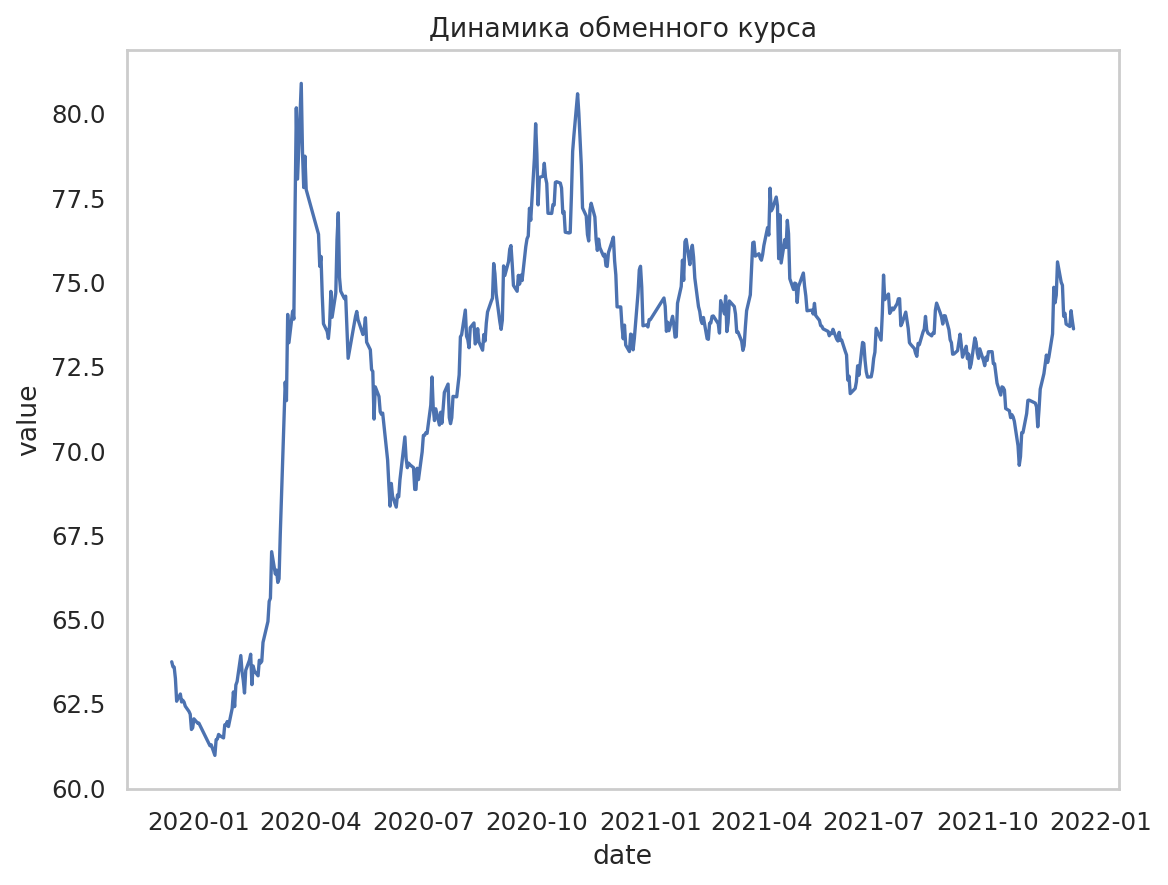

In [3]:

plt.figure(figsize=(8, 6), dpi=80)

plt.plot(df_doll['data'], df_doll['curs'])
plt.title('Динамика обменного курса')
plt.xlabel('date')
plt.ylabel('value')
plt.grid()

In [4]:
new_mos = pd.DataFrame({'Date': df_mosprime['Дата ставки'], 'Rate_mos': df_mosprime['ON']})
new_doll = pd.DataFrame({'Date': df_doll['data'], 'Rate_doll': df_doll['curs']})
new_sofr = pd.DataFrame({'Date': df_sofr['Effective Date'], 'Rate_sofr': df_sofr['Rate (%)']})

In [5]:
merged_df = pd.merge(new_mos, new_sofr, on='Date')
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df.rename(columns={'value_x': 'Rate_mos', 'value_y': 'Rate_sofr'}, inplace=True)
data = pd.merge(merged_df, new_doll, on='Date')

In [6]:
data

,Date,Rate_mos,Rate_sofr,Rate_doll
0,2021-12-10,7.69,0.05,73.5998
1,2021-12-09,7.72,0.05,73.8453
2,2021-12-08,7.68,0.05,74.1399
3,2021-12-07,7.51,0.05,73.6694
4,2021-12-03,7.47,0.05,74.0637
...,...,...,...,...
372,2019-12-17,6.2,1.54,62.7686
373,2019-12-13,6.34,1.54,63.2257
374,2019-12-12,6.45,1.53,63.5653
375,2019-12-11,6.52,1.54,63.5788


In [7]:
temp_df=pd.DataFrame()
temp_df['Rate_mos'] = merged_df['Rate_mos']
temp_df['Rate_sofr'] = merged_df['Rate_sofr']
# Будем считать приросты логарифмов для обменного курса
# так как в модели приросты выражаются через деление прошлого значения
temp_df['Rate_doll'] = np.log(new_doll['Rate_doll'])

In [8]:
temp_df

,Rate_mos,Rate_sofr,Rate_doll
0,7.69,0.05,4.298642
1,7.72,0.05,4.301972
2,7.68,0.05,4.305954
3,7.51,0.05,4.299588
4,7.59,0.05,4.300581
...,...,...,...
464,6.21,1.62,4.126352
465,6.34,1.54,4.124458
466,6.45,1.53,4.124796
467,6.52,1.54,4.118474


In [9]:
temp_df['Rate_mos'] = pd.to_numeric(temp_df['Rate_mos'], errors='coerce')

# Convert the column to a float
temp_df['Rate_mos'] = temp_df['Rate_mos'].astype(float)
# print(temp_df.dtypes)

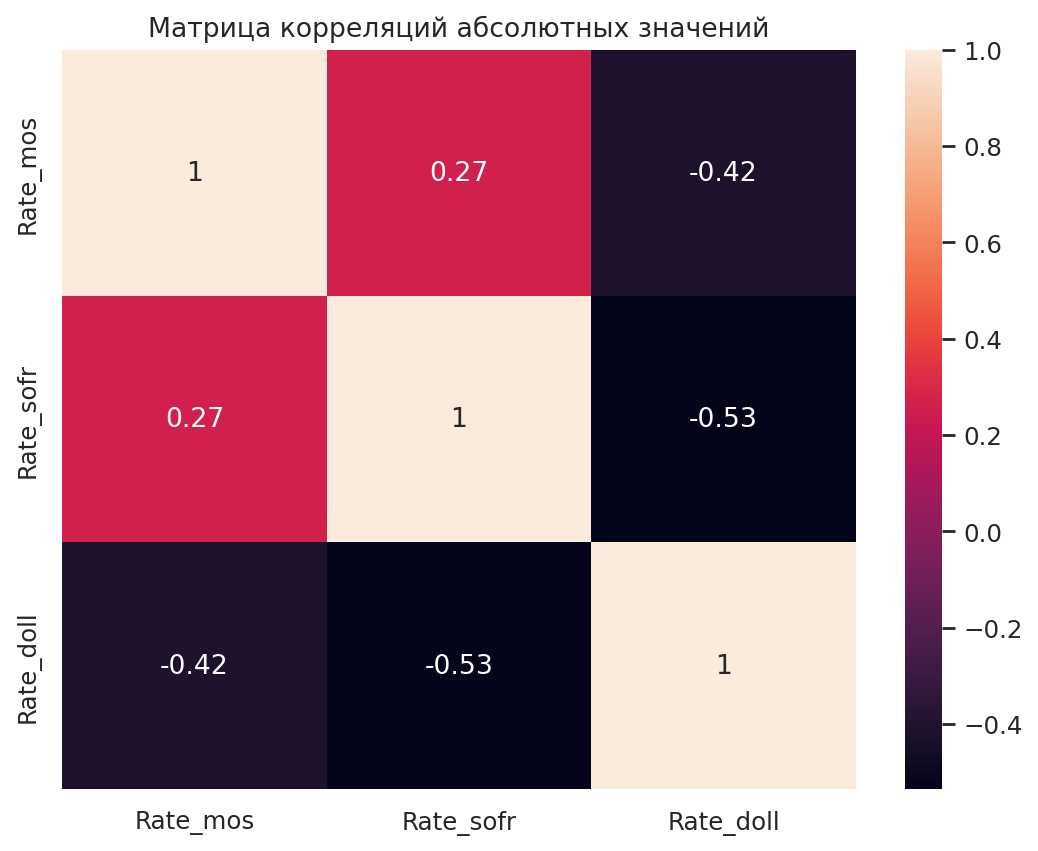

In [10]:
plt.figure(figsize=(8, 6), dpi=80)

plt.title('Матрица корреляций абсолютных значений')
sns.heatmap(temp_df.corr(), annot=True)
plt.show()

In [11]:
temp_df.corr()

,Rate_mos,Rate_sofr,Rate_doll
Rate_mos,1.000000,0.265058,-0.420171
Rate_sofr,0.265058,1.000000,-0.534535
Rate_doll,-0.420171,-0.534535,1.000000


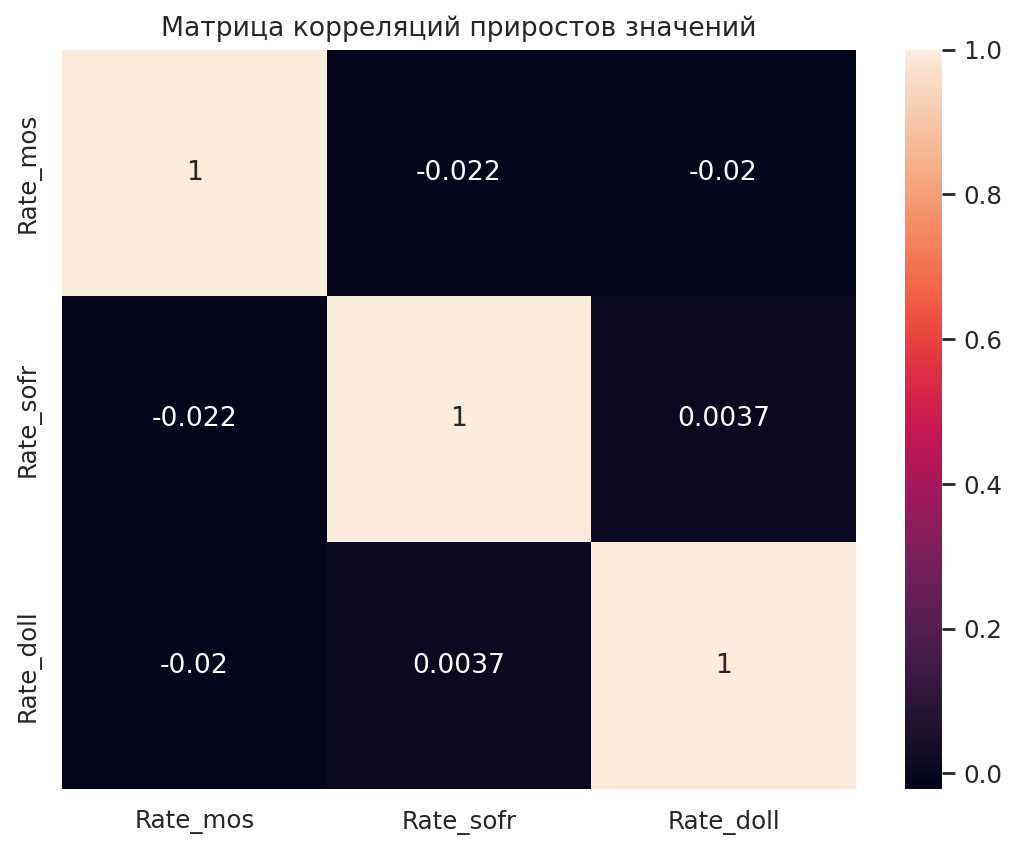

In [12]:
diff_df = temp_df.diff(1)[1:]

plt.figure(figsize=(8, 6), dpi=80)

plt.title('Матрица корреляций приростов значений')
sns.heatmap(diff_df.corr(), annot=True)
plt.show()

# Модельки для симуляции

## CIR с пуассоновскими джампами

$dr_t = a(b - r_t)dt + \sigma \sqrt{r_t}dW_t + \psi dN_t,$

где $N_t$ -- пуассоновский процесс с интенсивностью $\lambda > 0,$

$\psi = max(0, \xi), \xi \sim N(0, \sigma ^ 2)$

(параметры по кризисным периодам)


Используя схему Эйлера-Муроямы, можно представить $r_t$ следующим образом


$$r_{t+1} = r_t + a(b - r_t) + \sigma \sqrt{r_t} (W_{t+1} - W_{t}) + \psi (N_{t+1} - N_{t}),$$

то есть

$$r_{t+1} = r_t + a(b - r_t) + \sigma \sqrt{r_t} \cdot \xi + \psi \nu,$$

где $\xi \sim N(0, \sigma ^ 2), \ \nu \sim Pois(\lambda)$

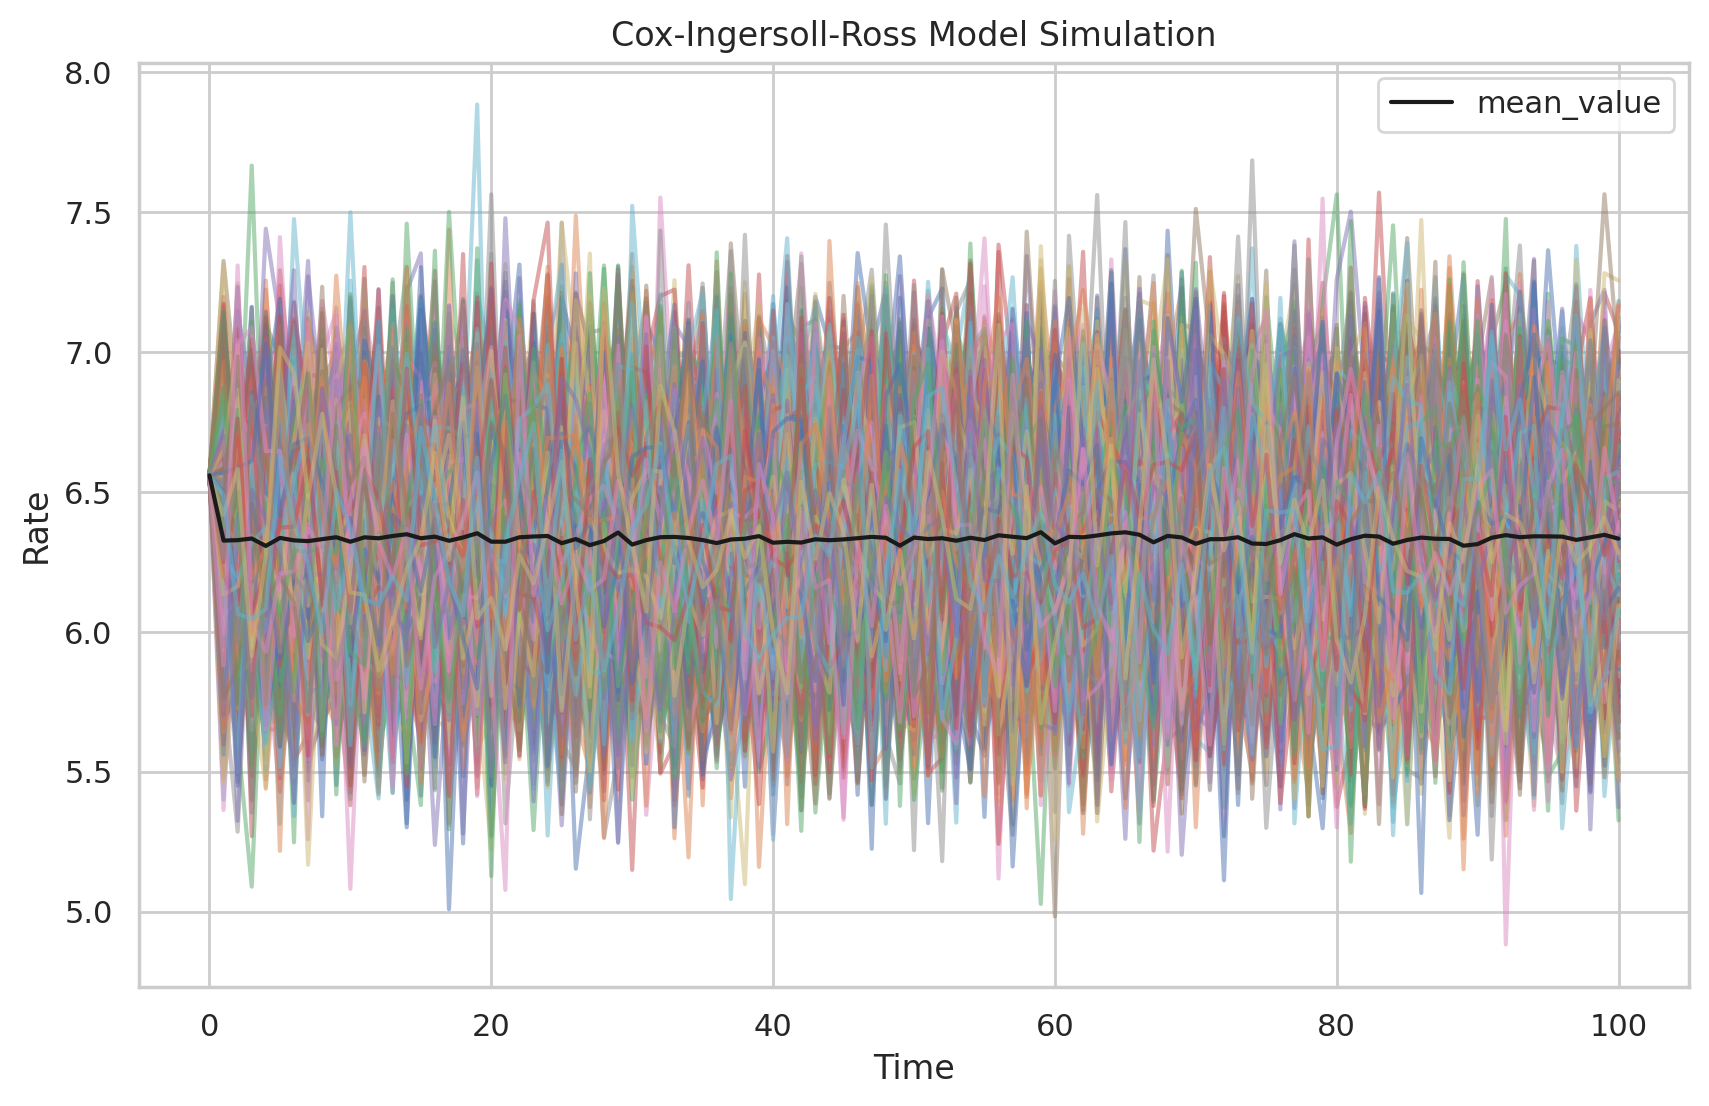

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def cir_model(a, b, sigma, r0, T, dt, num_paths):
    # Time grid
    t = np.arange(0, T+dt, dt)
    num_steps = len(t)

    # Initialize arrays to store the paths
    paths = np.zeros((num_paths, num_steps))
    paths[:, 0] = r0

    for i in range(1, num_steps):
        # Generate random normal variables
        dW = np.random.normal(0, np.sqrt(dt), num_paths)

        # Update the CIR process using Euler-Maruyama method
        paths[:, i] = paths[:, i-1] + a * (b - paths[:, i-1]) * dt + sigma * np.sqrt(paths[:, i-1]) * dW

        # Ensure that interest rates are non-negative
        paths[:, i] = np.maximum(paths[:, i], 0)

    return t, paths

def plot_paths(t, paths, title = 'Cox-Ingersoll-Ross Model Simulation'):
    mean = paths.mean(axis = 0)
    plt.figure(figsize=(10, 6))
    plt.plot(t, paths.T, alpha=0.5)
    plt.plot(mean, label = 'mean_value', color = 'k')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Rate')
    plt.legend()
    plt.show()

# Parameters
r_t = df_mosprime['ON'].values
a = 1.03
b = np.mean(df_mosprime['ON'].values[-10:])
sigma = np.std(df_mosprime['ON'].values[-10:])
r_0 = r_t[-1]
T = 100.0
dt = 1  # Daily time step
num_paths = 1000

# Simulate CIR model
t, paths = cir_model(a, b, sigma, r_0, T, dt, num_paths)

# Plot the simulated paths
# print(r_t)
plot_paths(t, paths)


In [14]:
import random
def CIR(r_0, a, b, sigma, N, num_traject = 1, dt = 1, dW = None):
  '''r_t - процентная ставка
      a - скорость возврата к среднему
      b - среднее
      sigma - волатильность
      N -  сколько точек мы моделируем
      num_traject- сколько  траекторий мы хотим увидеть
      dW - приращения случайной величины
      dt - какой масштаб мы берем по времени'''
  #моделируем матрицу приращений винеровского процесса
  #если на сказано обратное, то мы генерирует обычные приращения dw
  #Это сделано, чтобы в будущем изменить случайную компоненту приращений
  # и сделать симуляции скореллированными друг с другом

  if dW is None:
    dW = np.sqrt(dt) * np.random.randn(num_traject, N-1)
    dW = np.hstack((np.zeros((num_traject, 1)), dW))
  t = np.linspace(0, N-1, N)

  r_predict = np.zeros((num_traject, N))
  for i, t_i in enumerate(t):
    if i == 0:
      #в качестве первого значения кладем последнее известное
      r_predict[:, i] =  r_0
    else:
      previous = r_predict[:, i-1]
      r_predict[:, i] = previous + a*(b - previous) + sigma * (previous) ** (1/2) * dW[:, i]

  return r_predict, t

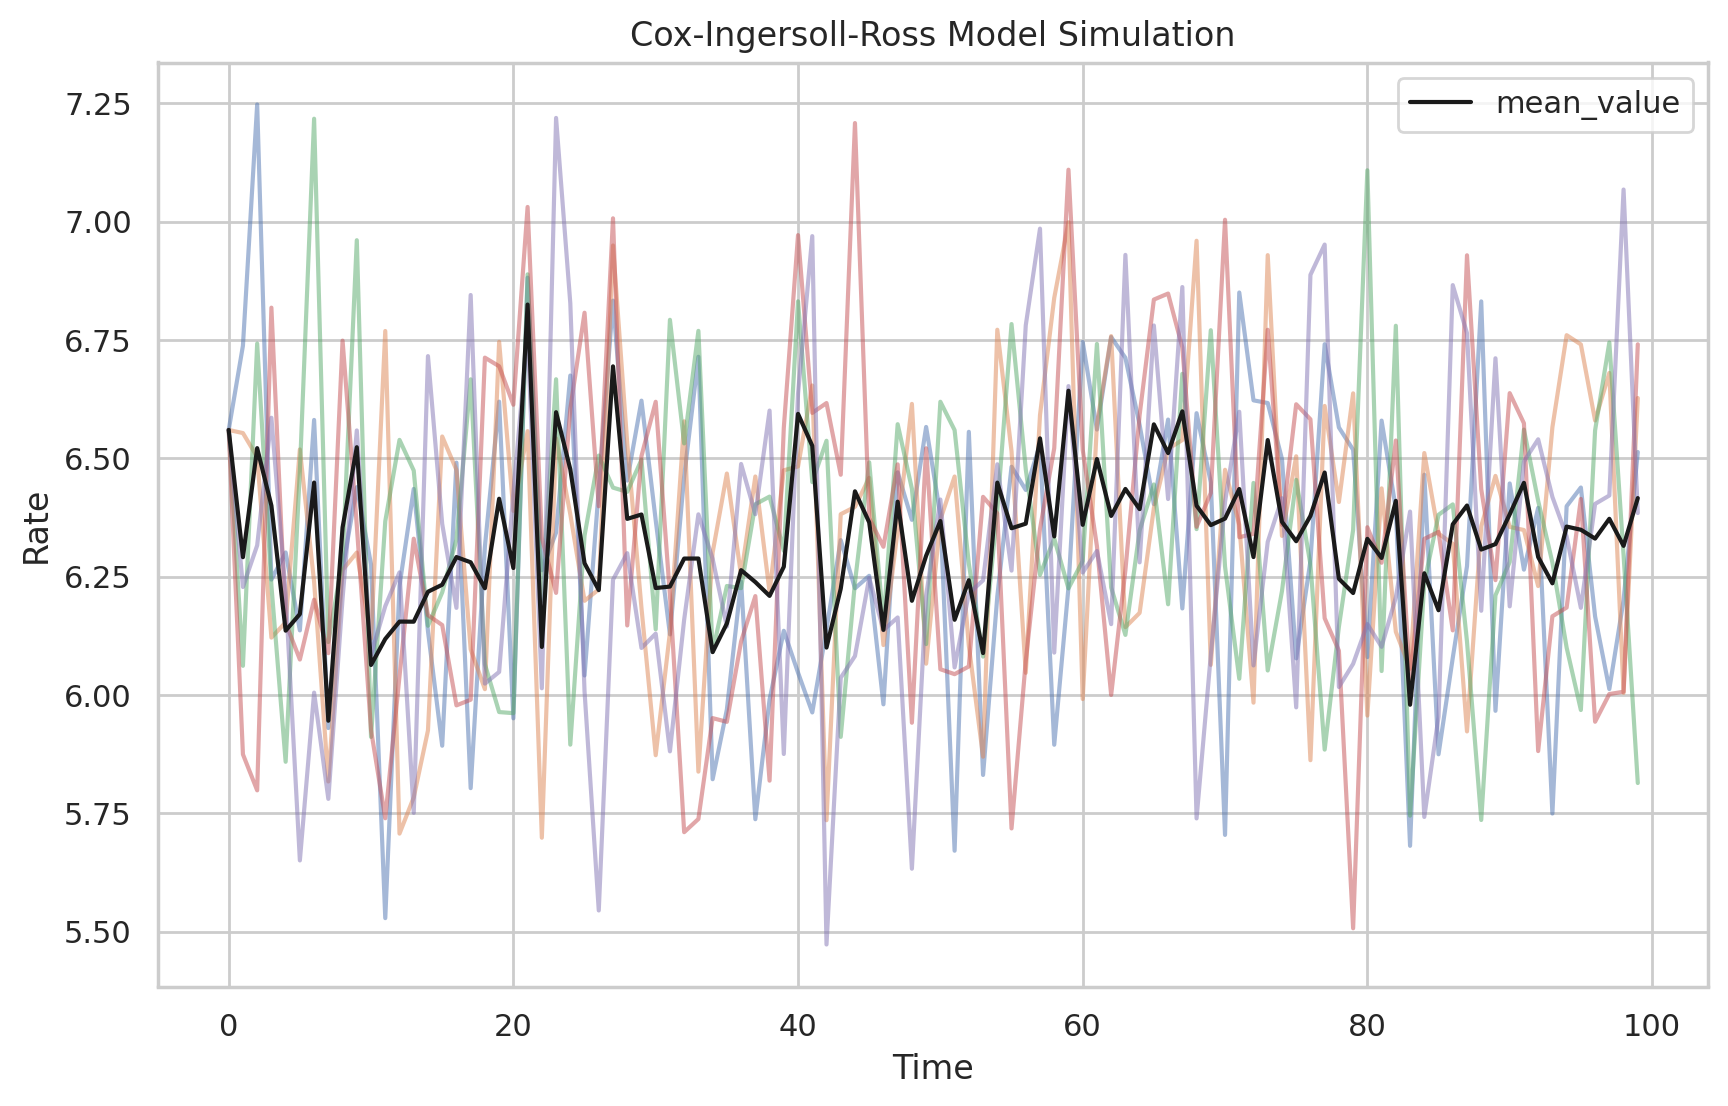

In [15]:
r_t = df_mosprime['ON'].values
# plt.plot(r_t)
r_0 = r_t[-1]
a = 1.03
b = np.mean(df_mosprime['ON'].values[-10:])
sigma = np.std(df_mosprime['ON'].values[-10:])
N = 100
results, t = CIR(r_0, a, b, sigma, N, num_traject = 5)
# t = np.linspace(0, N, N+1)
# list(enumerate(t))
plot_paths(t, results)
# plt.plot(t, results.T, alpha=0.5)
# plt.show()

## Обменный курс

$$\dfrac{dX_t}{X_t} = (r_t^{for} - r_t^{dom})dt + \sigma dW_t$$

$$\dfrac{X_{t+1} - X_t}{X_t} = (r_t^{for} - r_t^{dom})dt + \sigma  (W_{t+1} - W_{t})$$

$$X_{t+1}  = X_t\left((r_t^{for} - r_t^{dom})dt + \sigma  (W_{t+1} - W_{t}) + 1\right)$$




In [16]:
def LogModel(r_dom, r_for, sigma, X0, N, num_traject, dt = 1, dW = None):
  '''r_dom - ставка национальной валюты,
    r_for - ставка иностранной валюты,
    sigma - волатильность
    X0 - стартовое значение курса,
    N - сколько шагов вперед мы делаем,
    dt - масштаб времени(шага),
    num_traject - количество симуляций,
    dW - аналогично CIR передается внешним параметром чтобы потом скоррелировать'''
  if dW is None:
    dW = np.sqrt(dt) * np.random.randn(num_traject, N-1)
    dW = np.hstack((np.zeros((num_traject, 1)), dW))
  t = np.linspace(0, N-1, N)
  X_pred = np.zeros((num_traject, N))

  for i, t_i in enumerate(t):
    if i == 0:
      X_pred[:, i] = X0
    else:
      previous = X_pred[:, i-1]
      #вычисляем детерменированную часть
      det = previous * (r_for[:, i-1] - r_dom[:, i-1]) * dt
      stoh = previous * sigma * dW[:, i]
      X_pred[:, i] = previous + det + stoh
  return X_pred, t

Результаты ниже чисто упражнение и проверка, что все работает

In [17]:
N = 252
dt = 1/252
num_traject = 250
r_dom = df_mosprime['ON'].values[-10:]
r0_dom = r_dom[-1]
a = 1.03
b = np.mean(r_dom)
sigma = np.std(r_dom)

r_dom_pred, t = CIR(r0_dom, a, b, sigma, N, dt = dt, num_traject = num_traject)
plot_paths(t, r_dom_pred, 'CIR for r_dom')

r_for = df_sofr['Rate (%)'].values[-10:]
r0_for = r_for[-1]
a = 1.03
b = np.mean(r_for)
sigma = np.std(r_for)

r_for_pred, t = CIR(r0_for, a, b, sigma, N, dt = dt, num_traject = num_traject)
plot_paths(t, r_for_pred, 'CIR for r_for')

fx = df_doll['curs'].values[-5:]
fx0 = fx[-1]
sigma = 0.04

fx_pred,t = LogModel(r_dom_pred, r_for_pred, sigma, fx0, N, dt = dt, num_traject = num_traject,  dW = None)
plot_paths(t, fx_pred, 'FX_rate')


Output hidden; open in https://colab.research.google.com to view.

# Холецкий

In [46]:
def correlated_random_variables(*vals, C, sigmas=None):
    '''
    vals - векторы реализаций случайных величин
    C - матрица корреляций
    sigmas - tuple стандартных отклонений для сл величин
    '''
    if sigmas is None:
        sigmas = np.eye(len(vals))
    else:
        sigmas = np.diag([*sigmas])

    L = np.linalg.cholesky(C)
    corr_transform = sigmas @ L

    three_dimensional_matrix = np.transpose(np.stack(vals), (1, 0, 2))
    three_dimensional = corr_transform @ three_dimensional_matrix
    dW_dom, dW_for, dW_exc = list(np.rot90(three_dimensional))[::-1]

    return dW_dom, dW_for, dW_exc

# Подбор гиперпараметров

Проведем оценку параметров, используя метод наименьших квадратов для аппроксимации данных к уравнению линейной регрессии.
Уравнение линейной регрессии будет принимать вид:
$$ \frac{\Delta X_t}{\sqrt{\sigma_t}} = \tilde{a} \frac{1}{\sqrt{\sigma_t}}+\tilde{b} \sqrt{\sigma_t}+ c \varepsilon_t \\  $$

 Логика вычисления каждого параметра:
1. a: вычисляется как  отрицательный коэффициент регрессии модели.
2. b: вычисляется как  последние данные из массива values.
3. sigma: вычисляется как стандартное отклонение между реальными данными и предсказанными данными.

In [19]:
new_mos = pd.DataFrame({'Date': df_mosprime['Дата ставки'], 'Rate_mos': df_mosprime['ON']})
new_doll = pd.DataFrame({'Date': df_doll['data'], 'Rate_doll': df_doll['curs']})
new_sofr = pd.DataFrame({'Date': df_sofr['Effective Date'], 'Rate_sofr': df_sofr['Rate (%)']})

In [20]:
merged_df = pd.merge(new_mos, new_sofr, on='Date')
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df.rename(columns={'value_x': 'Rate_mos', 'value_y': 'Rate_sofr'}, inplace=True)
data = pd.merge(merged_df, new_doll, on='Date')
data['Rate_mos'] = pd.to_numeric(data['Rate_mos'], errors='coerce')
data['Rate_mos'] = data['Rate_mos'].fillna(method='ffill')

In [21]:
date_start = '2021-12-10'
days = 365
current_date = pd.to_datetime(date_start)
date_start = current_date - pd.Timedelta(days = days)
mask1 = data['Date']>date_start
mask2 = data['Date']<=current_date
data = data[mask1&mask2]
data.sort_values(by = 'Date', inplace = True)

In [22]:
import numpy as np
from sklearn.linear_model import LinearRegression

def calculate_CIR_parameters(values):
    sigma_sqrt = np.sqrt(values[:-1])
    y_diff = np.diff(values) / sigma_sqrt
    x1 = 1.0 / sigma_sqrt
    x2 = sigma_sqrt
    X_matrix = np.concatenate([x1.reshape(-1, 1), x2.reshape(-1, 1)], axis=1)
    regression_model = LinearRegression(fit_intercept=False)
    regression_model.fit(X_matrix, y_diff)
    regression_coeff = regression_model.coef_[0]
    a_param = -regression_model.coef_[1]
    b_param = values[-1]
    y_predicted = regression_model.predict(X_matrix)
    c_param = np.std(y_diff - y_predicted)

    calculated_params = dict()
    calculated_params['a'] = a_param
    calculated_params['b'] = b_param
    calculated_params['sigma'] = c_param
    return calculated_params

In [23]:
rub_abs = calculate_CIR_parameters(data['Rate_mos'].values)
print(rub_abs)

{'a': 0.0004156498629850772, 'b': 7.69, 'sigma': 0.05403056653661349}


In [24]:
sofr_abs = calculate_CIR_parameters(data['Rate_sofr'].values)
print(sofr_abs)

{'a': 0.05641560416981196, 'b': 0.05, 'sigma': 0.04812578051056543}


In [25]:
def calculate_sigma(df_values):
    # Выполним ряд операций для подсчета сигмы
    delta_t = 1
    df_values = pd.DataFrame(temp_df, columns=temp_df.columns)
    data = df_values.copy()
    data['change_fx'] = df_values.iloc[:, 0].diff().shift(-1)
    data['y_values'] = (data['change_fx'] / temp_df['Rate_doll']) - (temp_df['Rate_sofr'] / 100 - temp_df['Rate_mos'] / 100) * delta_t
    data['x_constant'] = np.ones(len(data))
    data.dropna(inplace=True)

    linear_reg = LinearRegression(fit_intercept=False).fit(data[['x_constant']], data['y_values'])
    beta_param = linear_reg.coef_[0]
    standard_error = np.sqrt(np.square(data['y_values'] - linear_reg.predict(data[['x_constant']])).sum()) / np.sqrt(data.shape[0])

    calculated_sigma = standard_error / np.sqrt(delta_t)

    return calculated_sigma
np.random.seed(42)
random.seed(42)
log_sigma = calculate_sigma(temp_df.values, )
log_sigma

0.02402366541697068

# Range Accrual

In [47]:
class RangeAccrual:
  '''
  .
  '''
  def __init__(self,
               date_start,
               date_end,
               low_bound,
               up_bound,
               nominal,
               dt = 1/252,
               CIR = None,
               r_t_predict_method = 'CIR',
               LogModel = None,
               HullWhite = None,
               data = data,
               num_traject = 100,
               days_backward = 365,
               illustrate = False):
    '''
    dt - масштаб времени,
    '''
    self.date_start = date_start
    self.date_end = date_end
    self.N = (pd.to_datetime(self.date_end)-pd.to_datetime(date_start)).days
    self.low_bound = low_bound
    self.up_bound = up_bound
    self.dt = dt
    self.nominal = nominal
    self.data = data
    self.num_traject = num_traject
    self.days_backward = days_backward
    self.illustrate = illustrate
    self.CIR = CIR
    self.LogModel = LogModel
    self.HullWhite = HullWhite
    error_str = "Наш класс поддерживает только методы 'CIR' и 'HullWhite' пожалуйста, выберите их"
    assert r_t_predict_method in ('CIR', 'HullWhite'), error_str
    #можно еще написать проверки, но это не поможет сути задания
    self.r_t_predict_method = r_t_predict_method


  def correlated_random_variables(*vals, C, sigmas=None):
      '''
      vals - векторы реализаций случайных величин
      C - матрица корреляций
      sigmas - tuple стандартных отклонений для сл величин
      '''
      if sigmas is None:
          sigmas = np.eye(len(vals))
      else:
          sigmas = np.diag([*sigmas])

      L = np.linalg.cholesky(C)
      corr_transform = sigmas @ L

      three_dimensional_matrix = np.transpose(np.stack(vals), (1, 0, 2))
      three_dimensional = corr_transform @ three_dimensional_matrix
      dW_dom, dW_for, dW_exc = list(np.rot90(three_dimensional))[::-1]

      return dW_dom, dW_for, dW_exc

  def get_historical_data(self, days):
    '''
    Оставляем историческую перспективу данных, для вычисления параметров
    Нам достаточно значений, которые идут на год назад
    '''
    current_date = pd.to_datetime(self.date_start)
    date_start = current_date - pd.Timedelta(days = days)
    mask1 = self.data['Date']>date_start
    mask2 = self.data['Date']<=current_date
    self.data = self.data[mask1&mask2]
    self.data.sort_values(by = 'Date', inplace = True)


  def make_simulations(self, ):

    def get_coeffs_CIR(r_t_real, a):
      b = np.mean(r_t_real)
      sigma = np.std(r_t_real)

      return a, b, sigma, r_t_real.iloc[-1]

    #беру из датафрейма исторические значения наших величин
    self.get_historical_data(self.days_backward)
    #матрица ковариаций
    diff_df = data.diff(1)[1:]
    q = diff_df.drop(columns=['Date'])
    corr_ = q.corr()
    C = corr_


    #генерируем приращения
    dW_dom, dW_for, dW_exc = list(self.dt**.5 * np.random.randn(3, self.num_traject, self.N-1))
    #Этот код лучше сохранить внутрь функции correlated_random_variables
    dW_dom = np.hstack((np.zeros((self.num_traject, 1)), dW_dom))
    dW_for = np.hstack((np.zeros((self.num_traject, 1)), dW_for))
    dW_exc = np.hstack((np.zeros((self.num_traject, 1)), dW_exc))


    dW_dom, dW_for, dW_exc = correlated_random_variables(dW_dom, dW_for, dW_exc, C=C)


    #параметры для иностранной ставки и симуляция
    a, b, sigma, r0_for = get_coeffs_CIR(self.data['Rate_sofr'], 0.1)

    #а потом мы провели более красивый метод подбора параметров в разделе Подбор Гиперпараметров
    # {'a': 0.05641560416981196, 'b': 0.05, 'sigma': 0.04812578051056543}
    a = 0.05641560416981196
    b = 0.05
    sigma = 0.04812578051056543
    if self.r_t_predict_method == 'CIR':
      r_t_for, t = self.CIR(r0_for, a, b, sigma,
                    N = self.N,
                    dt = self.dt,
                    num_traject = self.num_traject, dW = dW_for)
    a = 0.05641560416981196
    b = 0.05
    sigma = 0.04812578051056543
    if self.r_t_predict_method == 'HullWhite':
      pass


    #параметры для нашей ставки и симуляция
    a, b, sigma, r0_dom = get_coeffs_CIR(self.data['Rate_mos'], 0.05)
    a = 0.0004156498629850772
    b = 7.69
    sigma = 0.05403056653661349
    if self.r_t_predict_method == 'CIR':

      # {'a': 0.0004156498629850772, 'b': 7.69, 'sigma': 0.05403056653661349}


      r_t_dom, t = self.CIR(r0_dom, a, b, sigma,
                    N = self.N,
                    dt = self.dt,
                    num_traject = self.num_traject, dW = dW_dom)
    if self.r_t_predict_method == 'HullWhite':
      pass

    #параметры для fx_rate и симуляция
    _, _, sigma, fx0 = get_coeffs_CIR(self.data['Rate_doll'], None)
    # sigma = 0.023961143540808638
    fx_t, t = self.LogModel(
                    r_dom = r_t_dom,
                    r_for = r_t_for,
                    sigma = sigma,
                    X0 = fx0,
                    N = self.N,
                    dt = self.dt,
                    num_traject = self.num_traject,
                    dW = dW_exc)

    return r_t_for, r_t_dom, fx_t


  def results_plotting(self, fx, r_for, r_dom):
    # date_rng = pd.date_range(start=self.date_start, end=self.date_end, freq = 'D').tolist()
    #------График Mosprime------
    mean = r_dom.mean(axis = 0)
    plt.figure(figsize=(10, 6))
    plt.plot(r_dom.T, alpha = 0.7)
    plt.plot(mean, label = 'mean_value', color = 'k')
    plt.title(f'Mosprime SM = {self.r_t_predict_method}')
    # plt.xticks(date_rng, rotation=45, ha='right')
    plt.show()
    #------График SOFR ------
    mean = r_for.mean(axis = 0)
    plt.figure(figsize=(10, 6))
    plt.plot(r_for.T, alpha = 0.7)
    plt.plot(mean, label = 'mean_value', color = 'k')
    plt.title(f'SOFR SM = {self.r_t_predict_method}')
    # plt.xticks(date_rng, rotation=45, ha='right')
    plt.show()

    #------График fx------
    mean = fx.mean(axis = 0)

    plt.figure(figsize=(10, 6))

    plt.plot(fx.T, alpha = 0.7)
    plt.plot(mean, label = 'mean_value', color = 'k')

    plt.axhline(y = self.low_bound,
                color = 'red',
                linestyle = '--',
                label = f'lower_bound = {self.low_bound}',
                linewidth = 1.5)

    plt.axhline(y = self.up_bound,
                color = 'red',
                linestyle = '--',
                label = f'upper_boud = {self.up_bound}',
                linewidth = 1.5)

    # plt.xticks(date_rng, rotation=45, ha='right')
    plt.xlabel('Time')
    plt.ylabel('FX_rate')

    plt.legend()
    plt.title('FX_rate simulations')
    plt.show()

  def calc_results(self, ):
    r_for, r_dom, fx = self.make_simulations()
    payoff_flags = []
    for fx_t in fx:
      payoff_flags.append(np.mean((fx_t > self.low_bound)&(fx_t < self.up_bound)).astype(int))
    RA = np.sum(payoff_flags) * self.nominal/len(payoff_flags)

    self.RA = RA,
    if self.illustrate:
      self.results_plotting(fx, r_for, r_dom)

    return (r_for, r_dom, fx), RA

In [50]:
date_start = '2021-12-10'
date_end = '2021-12-31'

low_bound = 30
up_bound = 80

nominal = 1000
dt = 1/252
num_traject = 100

simulation_method = 'CIR'

data['Rate_mos'] = pd.to_numeric(data['Rate_mos'], errors='coerce')
data['Rate_mos'] = data['Rate_mos'].fillna(method='ffill')

np.random.seed(42)
range_accrual = RangeAccrual(
               date_start = date_start,
               date_end = date_end,
               low_bound = low_bound,
               up_bound = up_bound,
               nominal = nominal,
               CIR = CIR,
               LogModel = LogModel,
               data = data,
               num_traject = num_traject,
               illustrate = True,
               r_t_predict_method = simulation_method)


(r_for, r_dom, fx), RA = range_accrual.calc_results()

Output hidden; open in https://colab.research.google.com to view.

In [51]:
print(f'Справедливая цена: {RA:.2f}')

Справедливая цена: 410.00


# Hull White **
**Бонусные главы


В качестве дополнительной модели была рассмотрена была использована модель Халла Вайта, потому что это родственная для CIR модель, которая так же используется дл симуляции процентных ставок

**Модель процесса для процентной ставки** - Процесс Халла-Вайта:

$$dr(t) = (\theta(t) - \alpha r(t))dt + \sigma dW_t,$$

где $\theta(t)$ - средняя ожидаемая ставка в момент t (значения кривой) Получаем с помощью интерполяции

$\alpha, \sigma$ - даны по условию задачи

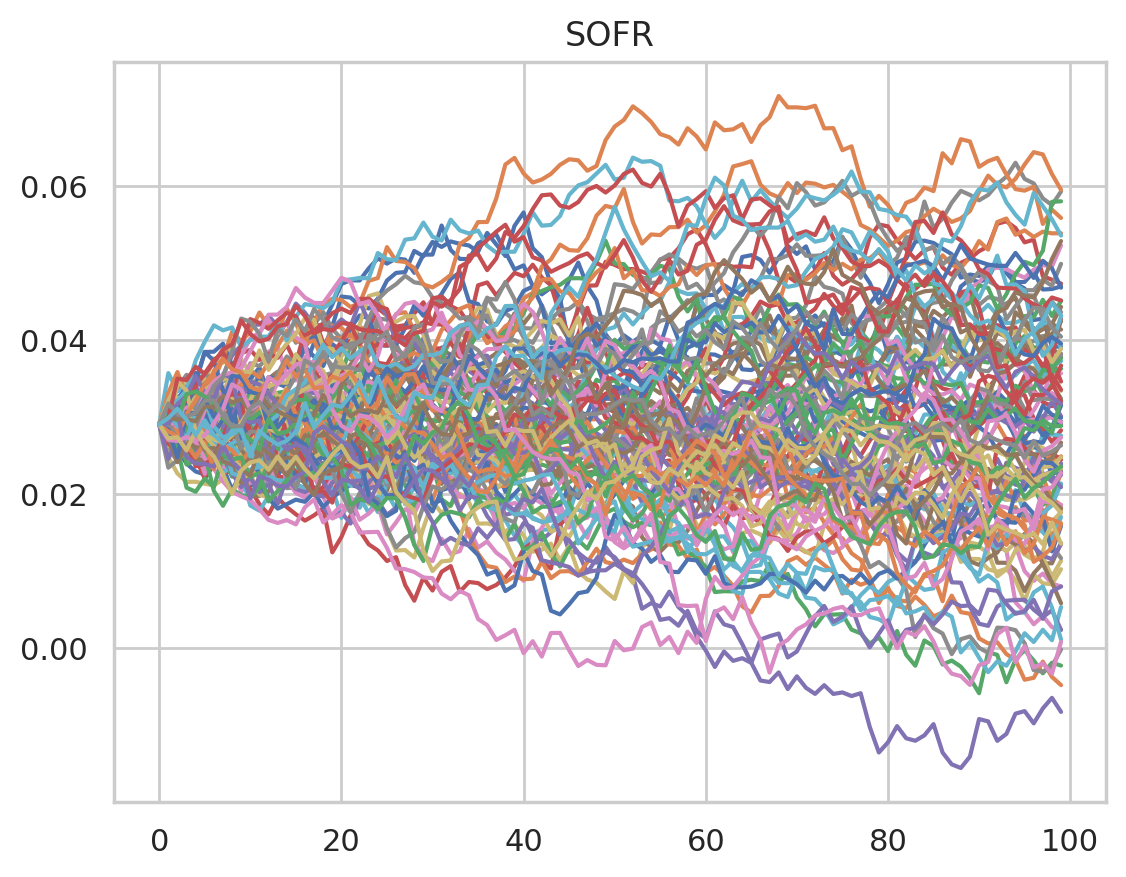

In [29]:
def read_curve_excel(path):
    df = pd.read_excel(path)
    df['Maturity'] = df['Maturity'].str[:-1]
    df['Maturity'] = df['Maturity'].astype(float)
    df['ds.rate'] /= 100

    return df

rub_irs = read_curve_excel('RUB IRS curve.xlsx')

usd_fra = read_curve_excel('USD FRA curve.xlsx')

import scipy.interpolate as interpolate
def get_interpolation(curve_df):
    '''
    curve_df - pd.DataFrame со столбцом Maturity и ds.rate
    '''
    return interpolate.interp1d(curve_df['Maturity'], curve_df['ds.rate'], kind='quadratic', fill_value='extrapolate')

def generate_hull_white(curve_df, alpha, sigma, N, dt, num_traject=1, dW=None):
    '''
    curve_df - pd.DataFrame со столбцом Maturity и ds.rate
    T - конечный момент
    dt - шаг симуляции
    num_traject - колво траекторий
    dW - сгенерированные приросты винеровского процесса (для корреляции)
    '''
    theta = get_interpolation(curve_df)

    if dW is None:
        dW = dt**.5*np.random.randn(num_traject, N-1)

    t = np.linspace(0, N-1, N)
    R = np.zeros((num_traject, N))
    for i, t_val in enumerate(t):
        if i == 0:
            R[:, i] = theta(t_val)
        else:

            prev_val = R[:, i-1]
            delta_theta = theta(t_val-dt)

            det_delta = (delta_theta - alpha*prev_val)*dt
            random_delta = sigma * dW[:, i-1]

            R[:, i] = prev_val + det_delta + random_delta

    return R, theta
alpha = 1.03
sigma= 0.03
N = 100
num_traject = 100

R_usd, theta = generate_hull_white(usd_fra, alpha, sigma, N, dt, num_traject)


plt.plot(R_usd.T)
plt.title('SOFR')
plt.show()